In [20]:
import pandas as pd
import numpy as np
import random 

# Import raw data

In [21]:
zone_coordinates = pd.read_csv('Data_SmallCase/Raw_Data_Process/zone_coordinates.csv')

zone_coordinates

,Zone,x-coordinate,y-coordinate
0,0,0,1
1,1,0,2
2,2,1,1
3,3,1,0


# Generate model inputs

## 1. OD distance matrix

In [22]:
zone_list = zone_coordinates['Zone'].tolist()
od_matrix = pd.DataFrame(index = zone_list, columns = zone_list)

for i in range(len(zone_list)):
    for j in range(len(zone_list)):
        if i == j:
            od_matrix.iloc[i,j] = 0
        else:
            # calculate the manhattan distance between two zones: |x1-x2|+|y1-y2|
            x_diff= zone_coordinates.iloc[i,1]-zone_coordinates.iloc[j,1]
            y_diff= zone_coordinates.iloc[i,2]-zone_coordinates.iloc[j,2]
            # if the slope is negative, the distance is the maximum of the x_diff and y_diff
            if x_diff * y_diff < 0:
                distance = max(abs(x_diff), abs(y_diff))
            else:
                distance = abs(x_diff) + abs(y_diff)
            od_matrix.iloc[i,j] = distance

# save the od_matrix to a csv file
od_matrix.to_csv('Data_MiddelCase/Model_Input/od_matrix.csv')

# display the complete matrix without hiding any rows or columns
pd.set_option('display.max_columns', len(od_matrix))
od_matrix.head(5)

,0,1,2,3
0,0,1,1,1
1,1,0,1,2
2,1,1,0,1
3,1,2,1,0


## 2. Rental demand generation for a zone

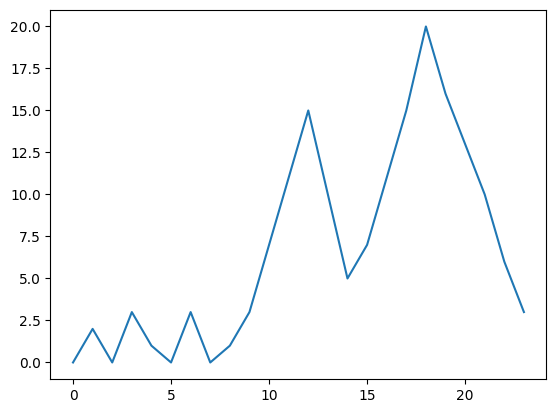

In [23]:
import random

def generate_demand(peak_1, peak_2, low_demand, tot_period):
    demand = []
    
    # Generate demand for the first 3/8 of total periods
    for i in range(int(3/8 * tot_period)):
        demand.append(random.randint(0, low_demand))
    
    # Generate demand for the next 1/8 of total periods increasing to peak_1
    for i in range(int(3/8 * tot_period), int(1/2 * tot_period)):
        demand.append(int(low_demand + ((peak_1 - low_demand) / (1/8 * tot_period)) * (i - (3/8 * tot_period))))
    
    # Generate demand for the next 1/8 of total periods decreasing to half of peak_1
    for i in range(int(1/2 * tot_period), int(5/8 * tot_period)):
        demand.append(int(peak_1 - ((peak_1 / (1/8 * tot_period)) * (i - (1/2 * tot_period)))))
    
    # Generate demand for the next 1/8 of total periods increasing to peak_2
    for i in range(int(5/8 * tot_period), int(3/4 * tot_period)):
        demand.append(int((peak_1 / 2) + ((peak_2 - (peak_1 / 2)) / (1/8 * tot_period)) * (i - (5/8 * tot_period))))
    
    # Generate demand for the remaining periods decreasing from peak_2 to 0
    for i in range(int(3/4 * tot_period), tot_period):
        demand.append(int(peak_2 - ((peak_2 / (1/4 * tot_period)) * (i - (3/4 * tot_period)))))
    
    return demand

# Example usage:
peak1 = 15
peak2 = 20
low_demand = 3
total_periods = 24

demand_pattern = generate_demand(peak1, peak2, low_demand, total_periods)

import matplotlib.pyplot as plt
plt.plot(demand_pattern)

Generate random rental demand in each zone in each period

In [24]:
zone_quantity = len(zone_coordinates)
total_periods = 6

# empty list to store the dataframes for each zone
dfs = []    

for i in range(zone_quantity):
    df = pd.DataFrame(columns=["Zone", "Start Period", "Duration", "Number of Couriers"])
    df["Zone"] = [i] * total_periods
    df["Start Period"] = list(range(total_periods))

    # random number of couriers needed for each period
    peak1 = random.randint(18, 22)
    peak2 = random.randint(20, 24)
    low_demand = random.randint(0,3)
    df["Number of Couriers"] = generate_demand(peak1, peak2, low_demand, total_periods)

    # set random shift duration of between total_periods/8 and total_periods/4
    df["Duration"] = [0 if x == 0 else random.randint(int(total_periods/8), int(total_periods/4)) for x in df["Number of Couriers"]]
    dfs.append(df)  

courier_schedule = pd.concat(dfs)

Generate random return demand from couriers shcedule

In [25]:
# mod 24 to get the hour of the day
courier_schedule["Hour"] = courier_schedule["Start Period"] % total_periods

In [26]:
courier_schedule["End Period"] = (courier_schedule["Start Period"] + courier_schedule["Duration"]) % total_periods

# create a dataframe to store the returning request of couriers
returning = pd.DataFrame(columns=["Zone_id", "Period", "Return_request"])
returning["Zone_id"] = courier_schedule["Zone"]
returning["Period"] = courier_schedule["End Period"]
returning["Return_request"] = courier_schedule["Number of Couriers"] 
returning = returning.groupby(["Zone_id", "Period"]).sum().reset_index() # agreegate rows with the same "Zone_id" and "Period" 

demand = pd.DataFrame(columns=["Zone_id", "Period", "Rental", "Return"])
demand["Zone_id"] = courier_schedule["Zone"]
demand["Period"] = courier_schedule["Start Period"] 
demand["Rental"] = courier_schedule["Number of Couriers"]
demand["Return"] = 0

# # match "Zone_id" and "Period" in the df of demand and returning, if these two columns have the same value, add the value of the column "Return_request" in the df "returning" to column "Return" in the df "demand"
for i in range(len(demand)):
    for j in range(len(returning)):
        if demand.iloc[i,0] == returning.iloc[j,0] and demand.iloc[i,1] == returning.iloc[j,1]:
            demand.iloc[i,3] = demand.iloc[i,3] + returning.iloc[j,2]

# add a column "Pure Rental" to the df "demand", which is the difference between the columns "Rental" and "Return", if the difference is negative, set it to 0
demand["Pure Rental"] = demand["Rental"] - demand["Return"]
for i in range(len(demand)):
    if demand.iloc[i,4] < 0:
        demand.iloc[i,4] = 0

# add a column "Pure Return" to the df "demand", which is the difference between the columns "Return" and "Rental", if the difference is negative, set it to 0
demand["Pure Return"] = demand["Return"] - demand["Rental"]
for i in range(len(demand)):
    if demand.iloc[i,5] < 0:
        demand.iloc[i,5] = 0

# remove the columns "Rental" and "Return" from the df "demand"
demand = demand.drop(["Rental", "Return"], axis=1)

# rename the column "Pure Rental" to "Rental" and the column "Pure Return" to "Return"
demand = demand.rename(columns={"Pure Rental": "Rental", "Pure Return": "Return"})

# check if there is any negative value in the column "Rental" and "Return", if there is, set it to 0
for i in range(len(demand)):
    if demand.iloc[i,1] < 0:
        demand.iloc[i,1] = 0
    if demand.iloc[i,2] < 0:
        demand.iloc[i,2] = 0


# export the demand dataframe to a csv file
demand.to_csv("Data_SmallCase/Model_Input/demand.csv", index=False)